# Model Training

## Importing

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from model.models import Model_1
from testing import test_model, pred_patches
from dataloader import DataLoader
from model.losses import FocalLoss, WBCE
from model.callbacks import UpdateAccuracy
from ops import reconstruct_image
import os
import json
import shutil
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import average_precision_score

## Parameters

In [2]:
# load the params-patches.json options
with open(os.path.join('v1', 'params-patches.json')) as param_file:
    params_patches = json.load(param_file)

# load the params-patches.json options
with open(os.path.join('v1', 'params-training.json')) as param_file:
    params_training = json.load(param_file)
    
#load the params-model.json options
with open(os.path.join('v1', 'params-model.json')) as param_file:
    params_model = json.load(param_file)

#load the shapes.json options
with open('shapes.json') as param_file:
    shapes_json = json.load(param_file)

In [3]:
patches_path = params_patches['patches_path']

train_path = os.path.join(patches_path, params_patches['train_sub'])
val_path = os.path.join(patches_path, params_patches['val_sub'])
test_path = os.path.join(patches_path, params_patches['test_sub'])
full_path = params_patches['full_path']


## Setting Dataloaders

In [4]:
dl_train = DataLoader(
    batch_size = params_training['batch_size'],
    data_path=os.path.join(train_path, params_patches['data_sub']),
    label_path=os.path.join(train_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3,
    shuffle=True, 
    limit=params_training['patch_limit']
)

dl_val = DataLoader(
    batch_size=params_training['batch_size'],
    data_path=os.path.join(val_path, params_patches['data_sub']),
    label_path=os.path.join(val_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3,
    limit=params_training['patch_limit']
)

dl_test = DataLoader(
    batch_size=params_training['batch_size'],
    data_path=os.path.join(test_path, params_patches['data_sub']),
    label_path=os.path.join(test_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3)

dl_full_test = DataLoader(
    batch_size=params_training['batch_size'],
    data_path=os.path.join(full_path, params_patches['data_sub']),
    label_path=os.path.join(full_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3)

## Model definition

In [5]:
model = Model_1(name='modelo_1')

metrics = {
}

weights = [0.1, 0.9, 0.0]

learning_rate = InverseTimeDecay(
    initial_learning_rate=1e-4, 
    decay_steps=params_training['learning_reduction']*len(dl_train),
    decay_rate = 0.01,
    staircase=True
    )

optimizers = {
    'opt': tf.keras.optimizers.Adam(learning_rate = learning_rate),
    'sar': tf.keras.optimizers.Adam(learning_rate = learning_rate),
    'fusion': tf.keras.optimizers.Adam(learning_rate = learning_rate),
}

class_indexes = [0, 1]

model.compile(
    optimizers = optimizers,
    loss_fn = WBCE,
    metrics_dict = metrics,
    class_weights = weights,
    class_indexes = class_indexes,
    run_eagerly=params_training['run_eagerly']
)

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_combined_f1score',
        patience = params_training['patience'],
        mode = 'max',
        restore_best_weights=True),
    UpdateAccuracy()
]


history = model.fit(
    x=dl_train,
    validation_data=dl_val,
    epochs=params_training['epochs_train'],
    callbacks=callbacks,
    verbose = 1
    )

Epoch 1/50
4/4 [==============================] - 9s 2s/step - opt_loss: 0.5449 - sar_loss: 0.5854 - fusion_loss: 0.8253 - loss: 1.9556 - opt_accuracy: 0.6284 - sar_accuracy: 0.6335 - fusion_accuracy: 0.6000 - combined_accuracy: 0.6466 - opt_f1score: 0.3043 - sar_f1score: 0.3359 - fusion_f1score: 0.2605 - combined_f1score: 0.2938 - val_opt_loss: 0.4557 - val_sar_loss: 0.4558 - val_fusion_loss: 0.4620 - val_loss: 1.3735 - val_opt_accuracy: 0.6667 - val_sar_accuracy: 0.6667 - val_fusion_accuracy: 0.6667 - val_combined_accuracy: 0.6667 - val_opt_f1score: 0.2274 - val_sar_f1score: 0.2290 - val_fusion_f1score: 0.3654 - val_combined_f1score: 0.3214
Epoch 2/50
4/4 [==============================] - 7s 2s/step - opt_loss: 0.5302 - sar_loss: 0.5751 - fusion_loss: 0.7824 - loss: 1.8877 - opt_accuracy: 0.6290 - sar_accuracy: 0.6372 - fusion_accuracy: 0.6148 - combined_accuracy: 0.6579 - opt_f1score: 0.3120 - sar_f1score: 0.3313 - fusion_f1score: 0.2794 - combined_f1score: 0.2994 - val_opt_loss: 0

## Show training history

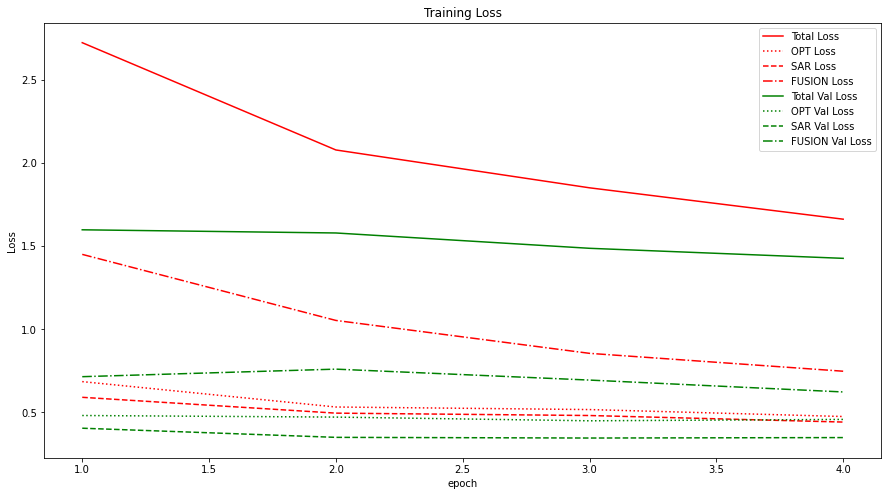

In [ ]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['loss'], 'r-',label='Total Loss')
plt.plot(x, history.history['opt_loss'], 'r:',label='OPT Loss')
plt.plot(x, history.history['sar_loss'], 'r--',label='SAR Loss')
plt.plot(x, history.history['fusion_loss'], 'r-.',label='FUSION Loss')

plt.plot(x, history.history['val_loss'], 'g-',label='Total Val Loss')
plt.plot(x, history.history['val_opt_loss'], 'g:',label='OPT Val Loss')
plt.plot(x, history.history['val_sar_loss'], 'g--',label='SAR Val Loss')
plt.plot(x, history.history['val_fusion_loss'], 'g-.',label='FUSION Val Loss')

plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('graphics/Loss.png')
plt.show()

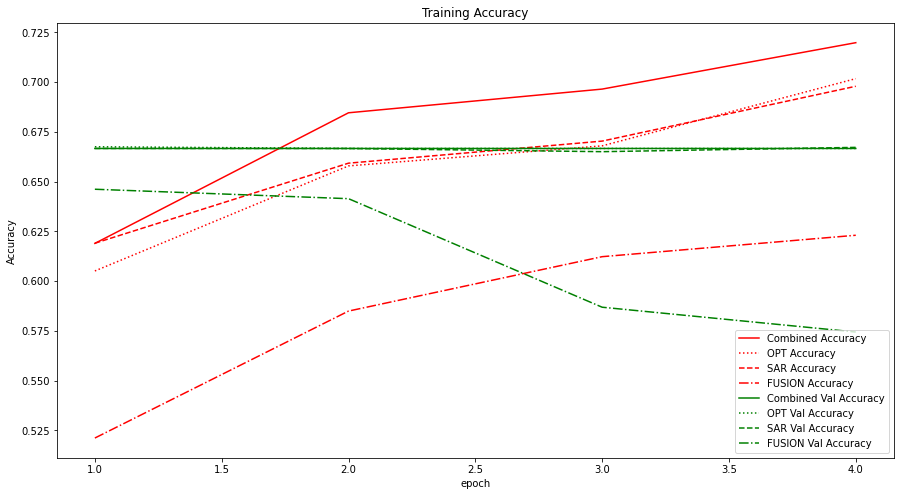

In [ ]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['combined_accuracy'], 'r-',label='Combined Accuracy')
plt.plot(x, history.history['opt_accuracy'], 'r:',label='OPT Accuracy')
plt.plot(x, history.history['sar_accuracy'], 'r--',label='SAR Accuracy')
plt.plot(x, history.history['fusion_accuracy'], 'r-.',label='FUSION Accuracy')

plt.plot(x, history.history['val_combined_accuracy'], 'g-',label='Combined Val Accuracy')
plt.plot(x, history.history['val_opt_accuracy'], 'g:',label='OPT Val Accuracy')
plt.plot(x, history.history['val_sar_accuracy'], 'g--',label='SAR Val Accuracy')
plt.plot(x, history.history['val_fusion_accuracy'], 'g-.',label='FUSION Val Accuracy')

plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('graphics/Accuracy.png')
plt.show()

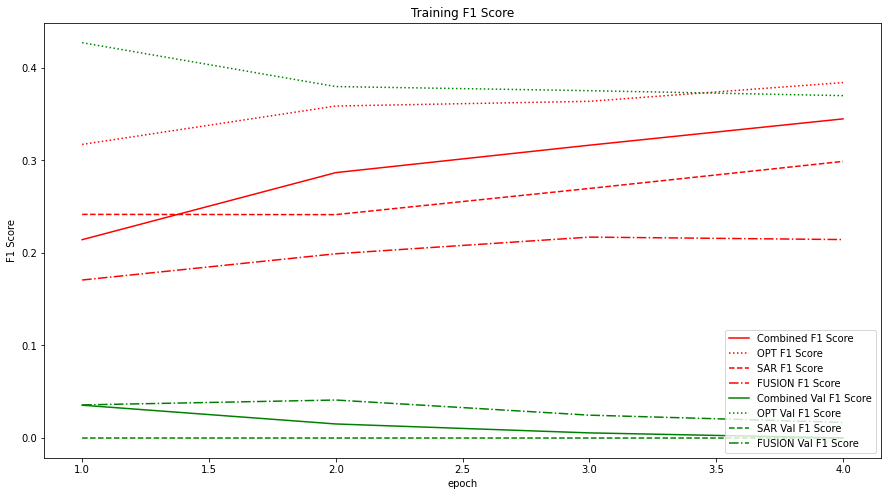

In [ ]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['combined_f1score'], 'r-',label='Combined F1 Score')
plt.plot(x, history.history['opt_f1score'], 'r:',label='OPT F1 Score')
plt.plot(x, history.history['sar_f1score'], 'r--',label='SAR F1 Score')
plt.plot(x, history.history['fusion_f1score'], 'r-.',label='FUSION F1 Score')

plt.plot(x, history.history['val_combined_f1score'], 'g-',label='Combined Val F1 Score')
plt.plot(x, history.history['val_opt_f1score'], 'g:',label='OPT Val F1 Score')
plt.plot(x, history.history['val_sar_f1score'], 'g--',label='SAR Val F1 Score')
plt.plot(x, history.history['val_fusion_f1score'], 'g-.',label='FUSION Val F1 Score')

plt.title('Training F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('graphics/F1score.png')
plt.show()

## Evaluation 

In [ ]:
pred_path = params_patches['pred_path']
shutil.rmtree(pred_path, ignore_errors=True)
os.makedirs(pred_path)

In [ ]:
opt_avg_prec_list = []
sar_avg_prec_list = []
fusion_avg_prec_list = []
combined_avg_prec_list = []

for tile_n in params_patches['test_tiles']:
    dl_test.set_tile(int(tile_n))

    shape_tile = shapes_json[str(tile_n)]

    y_true = np.load(os.path.join(params_patches['tiles_path'], params_patches['label_sub'], f'label_{tile_n:02d}.npy'))
    y_true = to_categorical(y_true, 3)

    predictions_opt = []
    predictions_sar = []
    predictions_fusion = []
    predictions_combined = []

    for batch in tqdm(range(len(dl_test))):
        pred = model.predict_on_batch(dl_test[batch][0])
        predictions_opt.append(pred[0])
        predictions_sar.append(pred[1])
        predictions_fusion.append(pred[2])
        predictions_combined.append(pred[3])  

    predictions_opt = np.concatenate(predictions_opt, axis=0)  
    predictions_sar = np.concatenate(predictions_sar, axis=0)  
    predictions_fusion = np.concatenate(predictions_fusion, axis=0)  
    predictions_combined = np.concatenate(predictions_combined, axis=0)  

    predictions_opt_rec = reconstruct_image(predictions_opt, params_patches['patch_stride'], shape_tile)
    predictions_sar_rec = reconstruct_image(predictions_sar, params_patches['patch_stride'], shape_tile)
    predictions_fusion_rec = reconstruct_image(predictions_fusion, params_patches['patch_stride'], shape_tile)
    predictions_combined_rec = reconstruct_image(predictions_combined, params_patches['patch_stride'], shape_tile)

    np.save(os.path.join(params_patches['pred_path'], f'pred_opt_{tile_n:02d}.npy'), predictions_opt_rec)
    np.save(os.path.join(params_patches['pred_path'], f'pred_sar_{tile_n:02d}.npy'), predictions_sar_rec)
    np.save(os.path.join(params_patches['pred_path'], f'pred_fusion_{tile_n:02d}.npy'), predictions_fusion_rec)
    np.save(os.path.join(params_patches['pred_path'], f'pred_combined_{tile_n:02d}.npy'), predictions_combined_rec)

    opt_avg_prec = average_precision_score(y_true[:, :, 1].flatten(), predictions_opt_rec[:,:,1].flatten())
    sar_avg_prec = average_precision_score(y_true[:, :, 1].flatten(), predictions_sar_rec[:,:,1].flatten())
    fusion_avg_prec = average_precision_score(y_true[:, :, 1].flatten(), predictions_fusion_rec[:,:,1].flatten())
    combined_avg_prec = average_precision_score(y_true[:, :, 1].flatten(), predictions_combined_rec[:,:,1].flatten())

    opt_avg_prec_list.append(opt_avg_prec)
    sar_avg_prec_list.append(sar_avg_prec)
    fusion_avg_prec_list.append(fusion_avg_prec)
    combined_avg_prec_list.append(combined_avg_prec)

    print(f'Precision Average (Class 1) of OPT prediction of tile {tile_n} is {opt_avg_prec:.4f}')
    print(f'Precision Average (Class 1) of SAR prediction of tile {tile_n} is {sar_avg_prec:.4f}')
    print(f'Precision Average (Class 1) of FUSION prediction of tile {tile_n} is {fusion_avg_prec:.4f}')
    print(f'Precision Average (Class 1) of COMBINED prediction of tile {tile_n} is {combined_avg_prec:.4f}')
    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (20,60))

    #categorical = to_categorical(y_true, params_model['classes'])
    img = Image.fromarray(np.uint8(y_true*255))
    ax[0].axis('off')
    ax[0].set_title(f'Label #{tile_n:02d}')
    ax[0].imshow(img)

    img = Image.fromarray(np.uint8(predictions_opt_rec[:,:,1]*255))
    ax[1].axis('off')
    ax[1].set_title(f'OPT Pred #{tile_n:02d}')
    ax[1].imshow(img, cmap='gray')

    img = Image.fromarray(np.uint8(predictions_sar_rec[:,:,1]*255))
    ax[2].axis('off')
    ax[2].set_title(f'SAR Pred #{tile_n:02d}')
    ax[2].imshow(img, cmap='gray')

    img = Image.fromarray(np.uint8(predictions_fusion_rec[:,:,1]*255))
    ax[3].axis('off')
    ax[3].set_title(f'FUSION Pred #{tile_n:02d}')
    ax[3].imshow(img, cmap='gray')

    Img = Image.fromarray(np.uint8(predictions_combined_rec[:,:,1]*255))
    ax[4].axis('off')
    ax[4].set_title(f'COMBINED Pred #{tile_n:02d}')
    ax[4].imshow(img, cmap='gray')
    
    plt.show()


In [7]:
model.save_weights('weights.h5')

In [ ]:
shape = (9202, 17729)

predictions_opt = []
predictions_sar = []
predictions_fusion = []
predictions_combined = []

for batch in tqdm(range(len(dl_full_test))):
    pred = model.predict_on_batch(dl_test[batch][0])
    predictions_opt.append(pred[0])
    predictions_sar.append(pred[1])
    predictions_fusion.append(pred[2])
    predictions_combined.append(pred[3])  

predictions_opt = np.concatenate(predictions_opt, axis=0)  
predictions_sar = np.concatenate(predictions_sar, axis=0)  
predictions_fusion = np.concatenate(predictions_fusion, axis=0)  
predictions_combined = np.concatenate(predictions_combined, axis=0)  


In [ ]:

predictions_opt_rec = reconstruct_image(predictions_opt, params_patches['patch_stride'], shape)
predictions_sar_rec = reconstruct_image(predictions_sar, params_patches['patch_stride'], shape)
predictions_fusion_rec = reconstruct_image(predictions_fusion, params_patches['patch_stride'], shape)
predictions_combined_rec = reconstruct_image(predictions_combined, params_patches['patch_stride'], shape)

np.save(os.path.join(params_patches['pred_path'], f'full_pred_opt.npy'), predictions_opt_rec)
np.save(os.path.join(params_patches['pred_path'], f'full_pred_sar.npy'), predictions_sar_rec)
np.save(os.path.join(params_patches['pred_path'], f'full_pred_fusion.npy'), predictions_fusion_rec)
np.save(os.path.join(params_patches['pred_path'], f'full_pred_combined.npy'), predictions_combined_rec)

In [21]:
a[0][0]

<tf.Tensor: shape=(3, 128, 128, 8), dtype=float32, numpy=
array([[[[0.09178171, 0.08239862, 0.04799396, ..., 0.08692839,
          0.04605263, 0.3919327 ],
         [0.09102675, 0.08164366, 0.04820967, ..., 0.08595772,
          0.04572908, 0.3766178 ],
         [0.09307593, 0.08326143, 0.04799396, ..., 0.08638913,
          0.047239  , 0.39182487],
         ...,
         [0.09329163, 0.07981018, 0.04432701, ..., 0.08229077,
          0.04971959, 0.32700604],
         [0.08789905, 0.0739862 , 0.04357205, ..., 0.07549611,
          0.04810181, 0.2965919 ],
         [0.08725194, 0.07323124, 0.04206213, ..., 0.07851596,
          0.04475841, 0.32862383]],

        [[0.08973253, 0.07851596, 0.04486627, ..., 0.08380069,
          0.04540553, 0.3830889 ],
         [0.08940897, 0.07970233, 0.04616049, ..., 0.08218291,
          0.04454271, 0.37219587],
         [0.09145816, 0.08283003, 0.04648404, ..., 0.08164366,
          0.04454271, 0.37650993],
         ...,
         [0.09102675, 0.079918